In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np

train_batch_size = 100
test_batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False)

class CNN_Model(nn.Module):
    def __init__(self, num_channels, fc_size):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(3, num_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.conv2 = nn.Conv2d(num_channels, num_channels * 2, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_channels * 2)
        self.conv3 = nn.Conv2d(num_channels * 2, num_channels * 4, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(num_channels * 4)
        
        dummy_input = torch.randn(1, 3, 32, 32)
        dummy_output = self._forward_features(dummy_input)
        num_features = dummy_output.view(dummy_output.size(0), -1).size(1)
        
        self.fc1 = nn.Linear(num_features, fc_size)
        self.fc2 = nn.Linear(fc_size, 10)

    def _forward_features(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.bn1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.bn2(x)
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = self.bn3(x)
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
def train_and_evaluate_model(model, train_loader, test_loader, optimizer, criterion, epochs=10):
    model.train()
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(epochs):
        total_train_loss = 0.0
        total_correct_train = 0
        total_samples_train = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            _, predicted_train = torch.max(outputs.data, 1)
            total_samples_train += labels.size(0)
            total_correct_train += (predicted_train == labels).sum().item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = total_correct_train / total_samples_train
        train_accuracies.append(train_accuracy)

        model.eval()
        total_test_loss = 0.0
        total_correct_test = 0
        total_samples_test = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                total_test_loss += criterion(outputs, labels).item()

                _, predicted_test = torch.max(outputs.data, 1)
                total_samples_test += labels.size(0)
                total_correct_test += (predicted_test == labels).sum().item()

        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        test_accuracy = total_correct_test / total_samples_test
        test_accuracies.append(test_accuracy)

        print(f'Model: Channels={}, FC Size={}, Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

    return train_losses, test_losses, train_accuracies, test_accuracies

models = []
for i in range(1, 11):
    num_channels = 16 * i
    fc_size = 120 * i
    model = CNN_Model(num_channels, fc_size)
    models.append(model)

results = []
for i, model in enumerate(models, 1):
    print(f"Training Model {i}:")
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_losses, test_losses, train_accuracies, test_accuracies = train_and_evaluate_model(model, trainloader, testloader, optimizer, loss_func)
    results.append((model.conv1.out_channels, model.fc1.out_features, train_losses, test_losses, train_accuracies, test_accuracies))

num_parameters = []
train_losses_list = []
test_losses_list = []
train_accuracies_list = []
test_accuracies_list = []

for result in results:
    num_parameters.append(result[0] * result[0] * 3 * 3 + result[1] * result[0] * 3 * 3 + result[1] + result[1] * 10)  # Calculating number of parameters
    train_losses_list.append(result[2])
    test_losses_list.append(result[3])
    train_accuracies_list.append(result[4])
    test_accuracies_list.append(result[5])

plt.figure(figsize=(8, 10))

plt.subplot(2, 1, 1)
for i in range(len(num_parameters)):
    plt.scatter(range(len(train_losses_list[i])), train_losses_list[i], label=f'{num_parameters[i]} parameters', color='blue', s=60)
    plt.scatter(range(len(test_losses_list[i])), test_losses_list[i], color='orange', s=60)

plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Test Loss'])

plt.subplot(2, 1, 2)
for i in range(len(num_parameters)):
    plt.scatter(range(len(train_accuracies_list[i])), train_accuracies_list[i], label=f'{num_parameters[i]} parameters', color='green', s=60)
    plt.scatter(range(len(test_accuracies_list[i])), test_accuracies_list[i], color='red', s=60)

plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train Accuracy', 'Test Accuracy'])

plt.tight_layout()
plt.show()


Files already downloaded and verified
Files already downloaded and verified
Training Model 1:
Model: Channels=16, FC Size=120, Epoch 1, Train Loss: 1.1452, Test Loss: 0.9393, Train Accuracy: 0.5895, Test Accuracy: 0.6641
Model: Channels=16, FC Size=120, Epoch 2, Train Loss: 0.7909, Test Loss: 0.8829, Train Accuracy: 0.7211, Test Accuracy: 0.6944
Model: Channels=16, FC Size=120, Epoch 3, Train Loss: 0.6429, Test Loss: 0.7806, Train Accuracy: 0.7751, Test Accuracy: 0.7324
Model: Channels=16, FC Size=120, Epoch 4, Train Loss: 0.5346, Test Loss: 0.7769, Train Accuracy: 0.8122, Test Accuracy: 0.7391
Model: Channels=16, FC Size=120, Epoch 5, Train Loss: 0.4401, Test Loss: 0.8190, Train Accuracy: 0.8441, Test Accuracy: 0.7349
Model: Channels=16, FC Size=120, Epoch 6, Train Loss: 0.3638, Test Loss: 0.8711, Train Accuracy: 0.8705, Test Accuracy: 0.7335
Model: Channels=16, FC Size=120, Epoch 7, Train Loss: 0.2963, Test Loss: 0.9175, Train Accuracy: 0.8959, Test Accuracy: 0.7409
Model: Channels=1

Model: Channels=112, FC Size=840, Epoch 4, Train Loss: 0.3218, Test Loss: 0.8190, Train Accuracy: 0.8891, Test Accuracy: 0.7675
Model: Channels=112, FC Size=840, Epoch 5, Train Loss: 0.2164, Test Loss: 0.8651, Train Accuracy: 0.9251, Test Accuracy: 0.7823
Model: Channels=112, FC Size=840, Epoch 6, Train Loss: 0.1674, Test Loss: 0.9596, Train Accuracy: 0.9432, Test Accuracy: 0.7761
Model: Channels=112, FC Size=840, Epoch 7, Train Loss: 0.1316, Test Loss: 1.0893, Train Accuracy: 0.9567, Test Accuracy: 0.7944
Model: Channels=112, FC Size=840, Epoch 8, Train Loss: 0.1199, Test Loss: 1.1111, Train Accuracy: 0.9606, Test Accuracy: 0.7732
Model: Channels=112, FC Size=840, Epoch 9, Train Loss: 0.1106, Test Loss: 1.1856, Train Accuracy: 0.9654, Test Accuracy: 0.7802
Model: Channels=112, FC Size=840, Epoch 10, Train Loss: 0.1056, Test Loss: 1.2272, Train Accuracy: 0.9671, Test Accuracy: 0.7862
Training Model 8:
Model: Channels=128, FC Size=960, Epoch 1, Train Loss: 1.1536, Test Loss: 0.9281, Tra

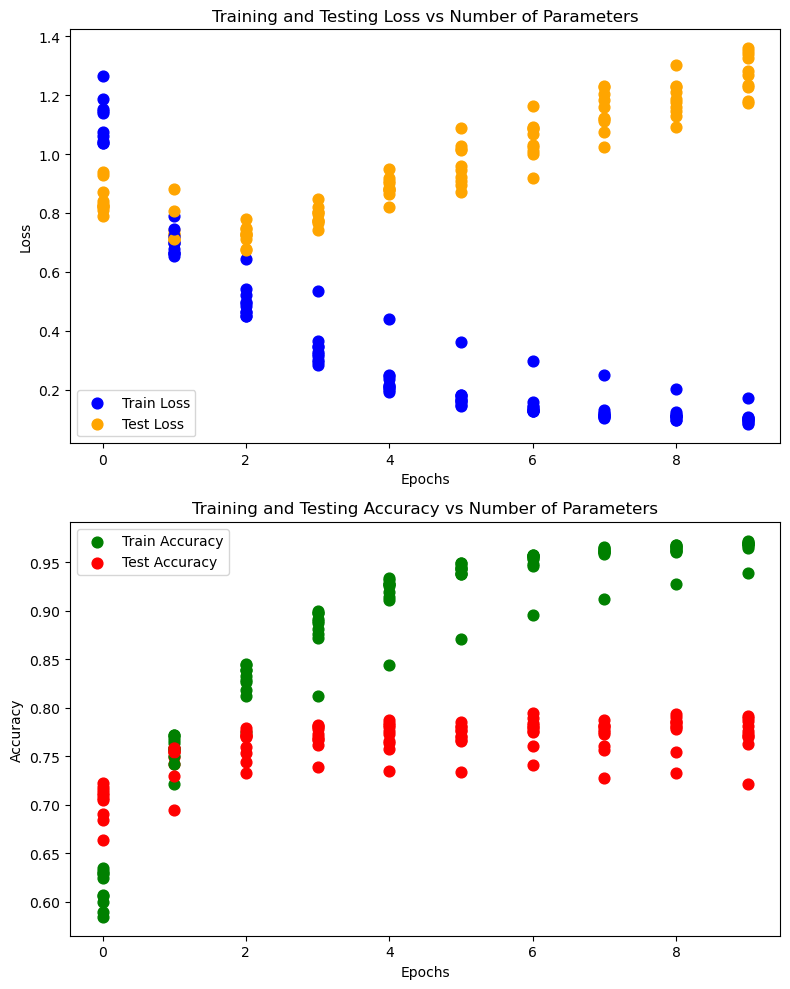